#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:180%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [EDA](#4)
* [DATA TRANSFORMS](#5)
* [MODEL TRAINING](#6)      
* [PLANNED WAY FORWARD](#7)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;
clear_output();

!pip install -q lightgbm==4.3.0 --force-reinstall;

clear_output();
import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk, pandas as pd;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}| Pandas = {pd.__version__}\n\n");
collect();

---> XGBoost = 2.0.3 | LightGBM = 4.3.0 | Catboost = 1.2.3
---> Sklearn = 1.2.2| Pandas = 2.2.1


CPU times: user 2.79 s, sys: 360 ms, total: 3.15 s
Wall time: 31.5 s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;
from functools import partial;

print();
collect();
clear_output();

CPU times: user 236 ms, sys: 17.4 ms, total: 254 ms
Wall time: 311 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     StratifiedGroupKFold as SGKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, 
                                     cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import roc_auc_score, mean_squared_error as mse, make_scorer;
from xgboost import DMatrix, XGBRegressor as XGBR;
from lightgbm import log_evaluation, early_stopping, LGBMRegressor as LGBMR;
from catboost import CatBoostRegressor as CBR, Pool;
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR, RandomForestRegressor as RFR;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.pruners import HyperbandPruner;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

clear_output();
print();
collect();


CPU times: user 511 ms, sys: 71.2 ms, total: 582 ms
Wall time: 869 ms


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 108 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* Included original data <br> * Added 1 extra feature <br> * 10x1 SKF ML models and Optuna ensemble|0.14829|Ensemble <br> Optuna|0.14610|
| **V2** |* Included multiple original data copies <br> * Added 1 extra feature <br> * 10x1 SKF ML models and Optuna ensemble|0.14464|Ensemble <br> Optuna|0.14572|
| **V3** |* Included original data <br> * Log transform without data leakage <br> * 10x1 SKF ML models and Optuna ensemble||Ensemble <br> Optuna||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #c2d6d6; border-bottom: 8px solid black" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 3;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = "Rings";
    episode            = 4;
    season             = 4;
    path               = f"/kaggle/input/playground-series-s{season}e{episode}";
    orig_path          = f"/kaggle/input/playgrounds4e04originaldata/Original.csv";
    
    dtl_preproc_req    = "Y";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    nb_orig            = 1;
    drop_nulls         = "N";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    
    # Model Training:- 
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.975;
    pseudolbl_low      = 0.00;
    
    n_splits           = 3 if test_req == "Y" else 10;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 100;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "Y";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'minimize';
    ntrials            = 10 if test_req == "Y" else 200;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': '#992600'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 106 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  targets          | Target column names                                     | list                  |
|  episode          | Episode Number                                          | integer               |
|  season           | Season Number                                           | integer               |    
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  nb_orig          | Number of original data copies to append                | int                   |   
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |  
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > APPROACH DETAILS<br><div> 
    
**Data columns**<br>
This is available in the original data description as [here](https://www.kaggle.com/competitions/playground-series-s4e4/discussion/488073) <br>
 <br>
<br>**Competition details and notebook objectives**<br>
1. This is a regression challenge to predict abalone age details. **RMSLE** is the metric for the challenge - **this needs to be minimized**<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>
<br>
**Model strategy** <br>
We start off with simple tree based ML models and an Optuna ensemble to create sample inputs for the submission. <br>

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > PREPROCESSING<br><div> 

In [6]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path, index_col = "id");
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        # Resetting original data columns-
        self.original.columns = self.train.columns;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original | {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\.|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.CYAN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.CYAN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.CYAN);
        display(self.original.head(5).style.format(precision = 3));
              
    def _AddSourceCol(self):
        self.train['Source']    = "Competition";
        self.test['Source']     = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([self.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
    
    def _ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"\n\nTrain shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");

            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");

            train.index = range(len(train));
            train.index.name = 'id';

        else:
            PrintColor(f"\nWe are using the competition training data only");
            train = self.train;
        return train;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        self.train = self._ConjoinTrainOrig();
        self.train.index = range(len(self.train));
        
        _ = self.train.drop(columns = [self.target, 'Source']).nunique();
        self.cat_cols  = _.loc[_ <=10].index.to_list();
        self.cont_cols = [c for c in _.index if c not in self.cat_cols + ['Source']];
        return self; 
            
collect();
print();

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs



In [7]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original | (90615, 9) (60411, 8) (4177, 9)

Train set head


,Sex,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.771,0.329,0.146,0.240,11
1,F,0.630,0.490,0.145,1.130,0.458,0.277,0.320,11
2,I,0.160,0.110,0.025,0.021,0.005,0.003,0.005,6
3,M,0.595,0.475,0.150,0.914,0.376,0.205,0.250,10
4,I,0.555,0.425,0.130,0.782,0.369,0.160,0.198,9



Test set head


,Sex,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.238,0.619,0.312,0.300
90616,M,0.580,0.460,0.160,0.983,0.478,0.220,0.275
90617,M,0.560,0.420,0.140,0.840,0.352,0.184,0.240
90618,M,0.570,0.490,0.145,0.874,0.352,0.186,0.235
90619,I,0.415,0.325,0.110,0.358,0.158,0.067,0.105



Original set head


,Sex,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight,Rings
id,,,,,,,,,
0,M,0.455,0.365,0.095,0.514,0.225,0.101,0.150,15
1,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7
2,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9
3,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10
4,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,0.52,0.12,0.07,0.28,0.45,0.55,0.60,0.65,0.68,0.72,0.81
Diameter,0.40,0.10,0.06,0.21,0.34,0.42,0.47,0.52,0.54,0.57,0.65
Height,0.14,0.04,0.00,0.07,0.11,0.14,0.16,0.18,0.20,0.21,1.13
Wholeweight,0.79,0.46,0.00,0.11,0.42,0.80,1.07,1.43,1.62,1.94,2.83
Wholeweight1,0.34,0.20,0.00,0.04,0.18,0.33,0.46,0.62,0.71,0.90,1.49
Wholeweight2,0.17,0.10,0.00,0.02,0.09,0.17,0.23,0.31,0.36,0.42,0.76
Shellweight,0.23,0.13,0.00,0.03,0.12,0.23,0.30,0.40,0.46,0.57,1.00



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           90615 non-null  object 
 1   Length        90615 non-null  float64
 2   Diameter      90615 non-null  float64
 3   Height        90615 non-null  float64
 4   Wholeweight   90615 non-null  float64
 5   Wholeweight1  90615 non-null  float64
 6   Wholeweight2  90615 non-null  float64
 7   Shellweight   90615 non-null  float64
 8   Rings         90615 non-null  int64  
 9   Source        90615 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.6+ MB


None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,0.52,0.12,0.07,0.28,0.45,0.55,0.60,0.65,0.68,0.72,0.80
Diameter,0.40,0.10,0.06,0.21,0.34,0.42,0.47,0.52,0.54,0.57,0.65
Height,0.14,0.04,0.00,0.07,0.11,0.14,0.16,0.18,0.20,0.21,1.09
Wholeweight,0.79,0.46,0.00,0.11,0.42,0.80,1.07,1.43,1.62,1.95,2.83
Wholeweight1,0.34,0.20,0.00,0.04,0.18,0.33,0.46,0.62,0.71,0.89,1.49
Wholeweight2,0.17,0.10,0.00,0.02,0.09,0.17,0.23,0.31,0.36,0.42,0.64
Shellweight,0.23,0.13,0.00,0.03,0.12,0.23,0.30,0.40,0.46,0.56,1.00



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 60411 entries, 90615 to 151025
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           60411 non-null  object 
 1   Length        60411 non-null  float64
 2   Diameter      60411 non-null  float64
 3   Height        60411 non-null  float64
 4   Wholeweight   60411 non-null  float64
 5   Wholeweight1  60411 non-null  float64
 6   Wholeweight2  60411 non-null  float64
 7   Shellweight   60411 non-null  float64
 8   Source        60411 non-null  object 
dtypes: float64(7), object(2)
memory usage: 4.6+ MB


None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Length,0.52,0.12,0.07,0.29,0.45,0.55,0.61,0.66,0.69,0.73,0.81
Diameter,0.41,0.10,0.06,0.22,0.35,0.42,0.48,0.52,0.55,0.58,0.65
Height,0.14,0.04,0.00,0.07,0.12,0.14,0.17,0.18,0.20,0.22,1.13
Wholeweight,0.83,0.49,0.00,0.13,0.44,0.80,1.15,1.48,1.69,2.14,2.83
Wholeweight1,0.36,0.22,0.00,0.05,0.19,0.34,0.50,0.65,0.74,1.00,1.49
Wholeweight2,0.18,0.11,0.00,0.03,0.09,0.17,0.25,0.33,0.38,0.48,0.76
Shellweight,0.24,0.14,0.00,0.04,0.13,0.23,0.33,0.42,0.48,0.62,1.00



Original information

<class 'pandas.core.frame.DataFrame'>
Index: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           4177 non-null   object 
 1   Length        4177 non-null   float64
 2   Diameter      4177 non-null   float64
 3   Height        4177 non-null   float64
 4   Wholeweight   4177 non-null   float64
 5   Wholeweight1  4177 non-null   float64
 6   Wholeweight2  4177 non-null   float64
 7   Shellweight   4177 non-null   float64
 8   Rings         4177 non-null   int64  
 9   Source        4177 non-null   object 
dtypes: float64(7), int64(1), object(2)
memory usage: 359.0+ KB


None


Unique and null values



,Sex,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight,Source
Train_Nunq,3,157,126,90,"3,175","1,799",979,"1,129",1
Test_Nunq,3,148,130,85,"3,037","1,747",960,"1,089",1
Original_Nunq,3,134,111,51,"2,429","1,515",880,926,1
Train_Nulls,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,0,0,0,0,0,0




Train shape before conjoining with original = (90615, 10)
Train shape after conjoining with original= (94792, 10)
Train shape after de-duping = (94792, 10)

CPU times: user 1.11 s, sys: 90.3 ms, total: 1.2 s
Wall time: 1.32 s


<a id="3.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: black; font-size:120%; text-align:left;padding:3.0px; background: #e5e5cc; border-bottom: 8px solid black" > INFERENCES<br><div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns with no nulls<br>
2. The dataset is quite moderate in size, so building a CV is fine. I expect a good CV-LB relation here and a less volatile LB at the end<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > EDA<br><div> 

In [8]:
%%time 

class FeaturePlotter(CFG, Preprocessor):
    """
    This class develops plots for the targets, continuous and category features
    """;
    
    def __init__(self):
        super().__init__();
        clear_output();
        
    def MakeTgtPlot(self):
        "This method returns the target plots";
        
        if self.ftre_plots_req == "Y": 
            fig, axes = plt.subplots(1,2, figsize = (14, 4), sharey = True, gridspec_kw = {'wspace': 0.35});
            for i, df in tqdm(enumerate([self.train, self.original]), f"Target plot- {self.target} ---> "):
                ax= axes[i];
                a = df[self.target].value_counts(normalize = True);
                a.sort_index().plot.bar(color = 'tab:blue', ax = ax);
                df_name = 'Train' if i == 0 else "Original";
                _ = ax.set_title(f"\n{df_name} data- {self.target}\n", **self.title_specs);
                ax.set_yticks(np.arange(0,0.21, 0.01), labels = np.around(np.arange(0,0.21, 0.01), 2), fontsize = 7.0)

            plt.tight_layout();
            plt.show();
                
    def MakeCatFtrePlots(self, cat_cols):
        "This method returns the category feature plots";
        
        if cat_cols != [] and self.ftre_plots_req == "Y":
            fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                                     gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

            for i, col in enumerate(cat_cols):
                ax = axes[i, 0] if len(cat_cols) > 1 else axes[0];
                a = self.train[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#007399');
                ax.set_title(f"{col}_Train", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;

                ax = axes[i, 1] if len(cat_cols) > 1 else axes[1];
                a = self.test[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#0088cc');
                ax.set_title(f"{col}_Test", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;

                ax = axes[i, 2] if len(cat_cols) > 1 else axes[2];
                a = self.original[col].value_counts(normalize = True);
                a.sort_index().plot.barh(ax = ax, color = '#0047b3');
                ax.set_title(f"{col}_Original", **self.title_specs);
                ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                              labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                              rotation = 90
                             );
                ax.set(xlabel = '', ylabel = '');
                del a;       

            plt.suptitle(f"Category column plots", **self.title_specs, y= 0.975);
            plt.tight_layout();
            plt.show();
            
    def MakeContColPlots(self, cont_cols):
        "This method returns the continuous feature plots";
        
        if self.ftre_plots_req == "Y":
            df = pd.concat([self.train[cont_cols].assign(Source = 'Train'), 
                            self.test[cont_cols].assign(Source = 'Test'),
                            self.original[cont_cols].assign(Source = "Original")
                           ], 
                           axis=0, ignore_index = True
                          );

            fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                                     gridspec_kw = {'hspace': 0.35, 
                                                    'wspace': 0.3, 
                                                    'width_ratios': [0.80, 0.20, 0.20, 0.20]
                                                   }
                                    );

            for i,col in enumerate(cont_cols):
                ax = axes[i,0];
                sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                            palette = ['#0039e6', '#ff5500', '#00b300'], 
                            ax = ax, linewidth = 2.1
                           );
                ax.set_title(f"\n{col}", **self.title_specs);
                ax.grid(**CFG.grid_specs);
                ax.set(xlabel = '', ylabel = '');

                ax = axes[i,1];
                sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                            color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                            fliersize= 2.25,
                            ax = ax);
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Train", **self.title_specs);

                ax = axes[i,2];
                sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                            color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                            ax = ax); 
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Test", **self.title_specs);

                ax = axes[i,3];
                sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                            color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                            ax = ax); 
                ax.set(xlabel = '', ylabel = '');
                ax.set_title(f"Original", **self.title_specs);

            plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                         y = 0.92, x = 0.50
                        );
            plt.tight_layout();
            plt.show();
     
    def CalcSkew(self, cont_cols):
        "This method calculates the skewness across columns";
        
        if self.ftre_plots_req == "Y": 
            skew_df = pd.DataFrame(index = cont_cols);
            for col, df in {"Train"   : self.train[cont_cols], 
                            "Test"    : self.test[cont_cols], 
                            "Original": self.original[cont_cols]
                           }.items():   
                skew_df = \
                pd.concat([skew_df, 
                           df.drop(columns =  [self.target, "Source", "id"], errors = "ignore").skew()],
                           axis=1).rename({0: col}, axis=1);

            PrintColor(f"\nSkewness across independent features\n");
            display(skew_df.transpose().style.format(precision = 2).background_gradient("PuBuGn"));

print();
collect();
  


CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 110 ms


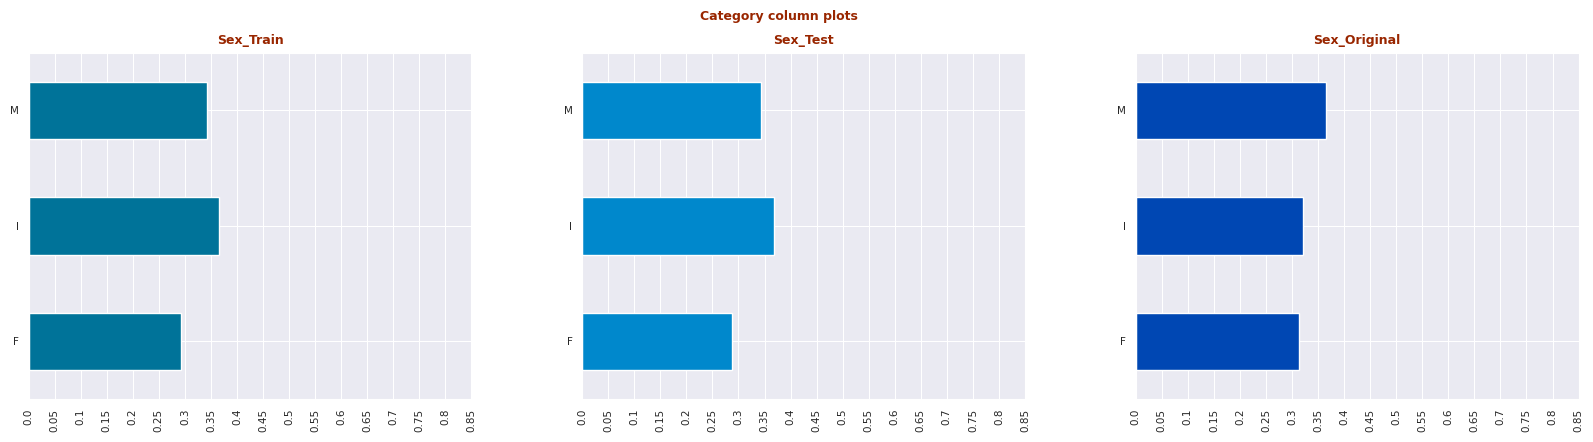

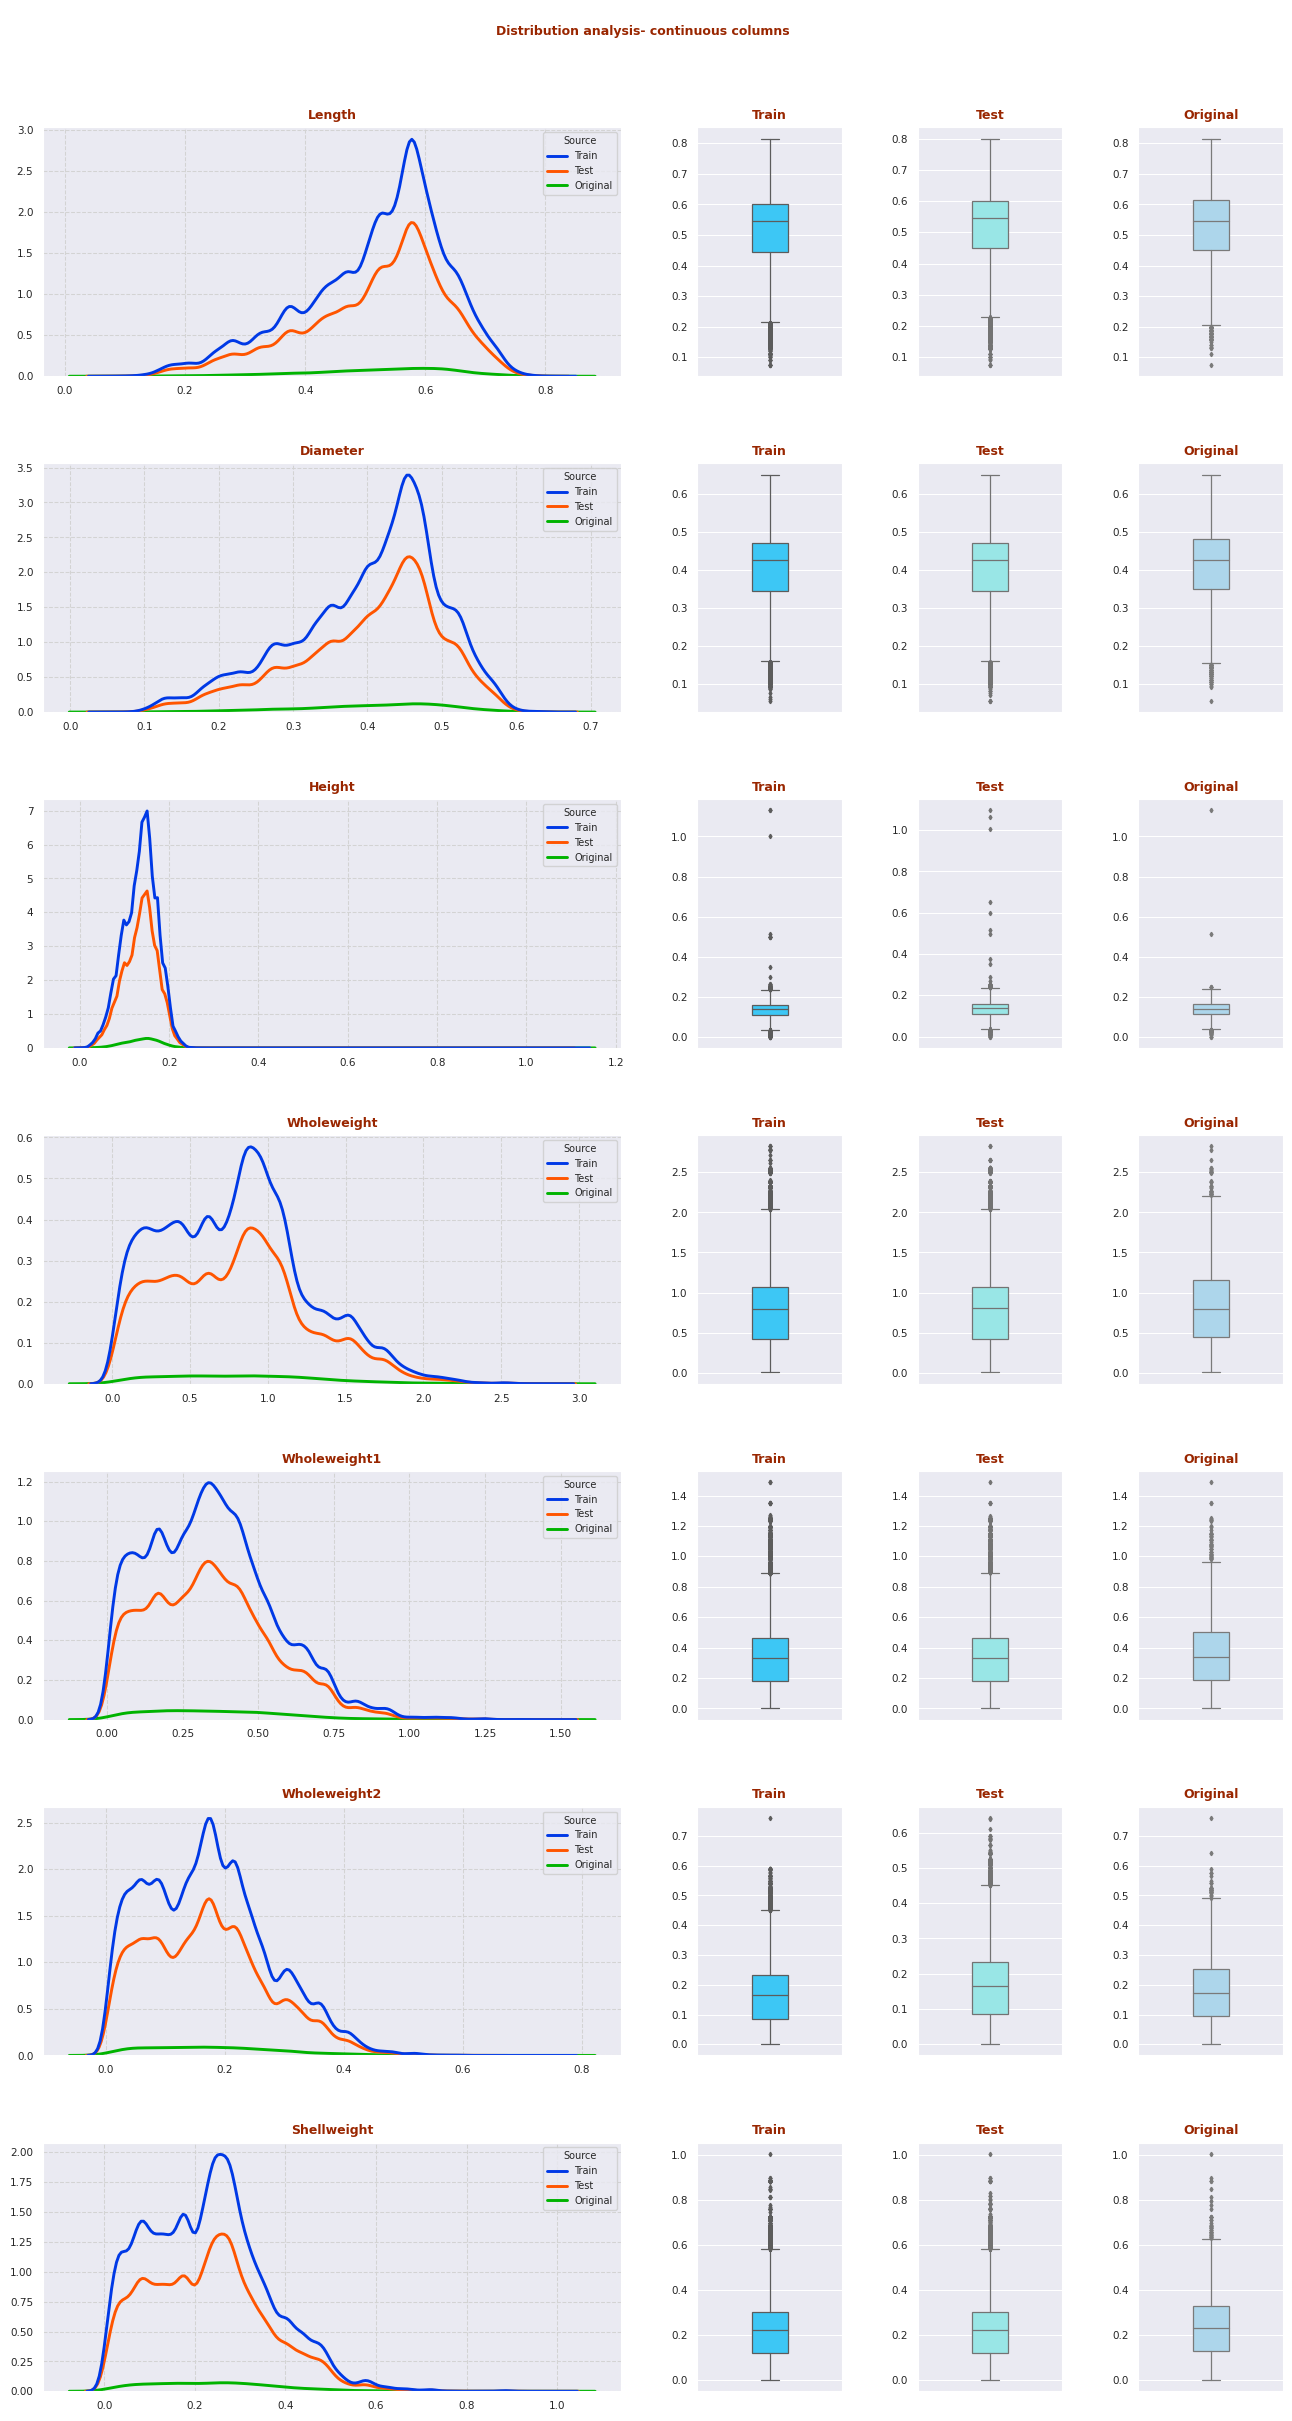

Target plot- Rings ---> : 0it [00:00, ?it/s]

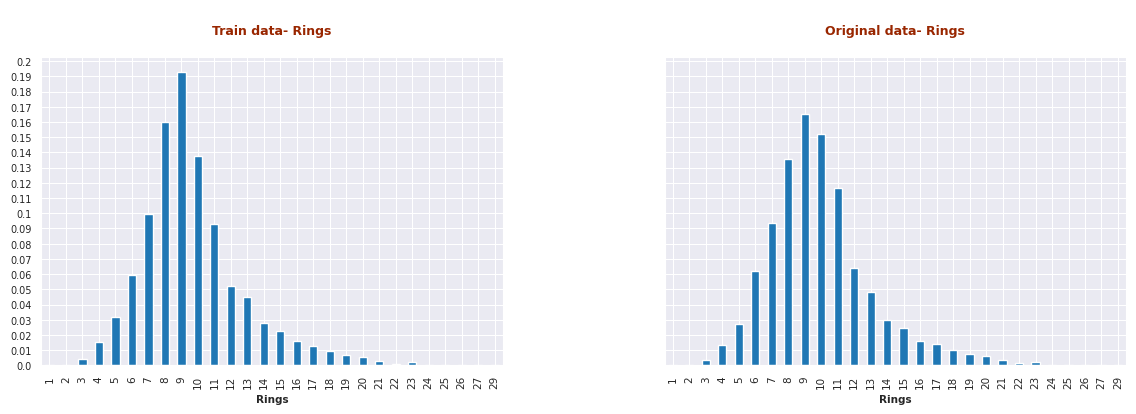






Skewness across independent features



,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight
Train,-0.73,-0.70,0.31,0.43,0.59,0.48,0.48
Test,-0.73,-0.70,0.55,0.44,0.59,0.48,0.47
Original,-0.64,-0.61,3.13,0.53,0.72,0.59,0.62



CPU times: user 23.6 s, sys: 2.34 s, total: 25.9 s
Wall time: 17 s


In [9]:
%%time 

plotter = FeaturePlotter();
plotter.MakeCatFtrePlots(cat_cols = pp.cat_cols)

print(f"\n\n\n");
plotter.MakeContColPlots(cont_cols = pp.cont_cols);

print(f"\n\n\n");
plotter.MakeTgtPlot();

print(f"\n\n\n");
plotter.CalcSkew(cont_cols = pp.cont_cols);

print();
collect();    

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > DATA TRANSFORMS<br><div> 

In [10]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        """
        Source- https://www.kaggle.com/code/mfmfmf3/clean-code-voting-regressor-base-3-models
        This function converts the column to a positive transform and takes its log
        """
        
        self.cols    = X.columns[1:-1]
        self.col_min = X[self.cols].min(axis=0)
        return self
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"];
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        It also reduces memory usage
        """;
        
        df = X.copy()
        for col in self.cols:
            df[col] = np.log1p(X[col] - self.col_min.loc[col])

        self.op_cols = df.columns
        df = self._reduce_mem(df)
        return df
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 185 ms, sys: 926 µs, total: 186 ms
Wall time: 186 ms


In [11]:
%%time 

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

if CFG.conjoin_orig_data == "Y" and CFG.nb_orig > 1:
    pp.train = pd.concat([pp.train.loc[pp.train.Source == "Competition"]] + [pp.train.loc[pp.train.Source == "Original"]] * CFG.nb_orig,
                  axis=0, ignore_index = True,
                 );
    PrintColor(f"\n---> Train data columns after appending {CFG.nb_orig} original data copies = {pp.train.shape}\n");

ygrp   = pp.train[CFG.target];
ytrain = pd.Series(np.log1p(pp.train[CFG.target]));
ytrain.name = CFG.target;

enc = \
ColumnTransformer([("Enc", OneHotEncoder(use_cat_names = True), pp.cat_cols)], 
                  remainder = 'passthrough',
                  verbose_feature_names_out= False
                 );

xform  = Pipeline(steps = [("Xfrm", Xformer()), ("E", enc)]);
Xtrain = xform.fit_transform(pp.train.drop(columns = CFG.target), ytrain);
Xtest  = xform.transform(pp.test.copy(deep = True));

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

# Checking the results:-
with np.printoptions(linewidth = 160):
    PrintColor(f"\n---> Train data columns after data pipeline\n");
    pprint(np.array(Xtrain.columns));

    PrintColor(f"\n---> Test data columns after data pipeline\n");
    pprint(np.array(Xtest.columns));
    PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");
    
print();
collect();


==================== Data transformation ==================== 

Start - end memory:-  6.51 -  3.98 Mb
Start - end memory:-  4.61 -  3.00 Mb

---> Train data



,Sex_F,Sex_I,Sex_M,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight,Source
0,1,0,0,0.39,0.32,0.14,0.57,0.28,0.14,0.21,Competition
1,1,0,0,0.44,0.36,0.14,0.76,0.38,0.24,0.28,Competition
2,0,1,0,0.08,0.05,0.02,0.02,0.00,0.00,0.00,Competition
3,0,0,1,0.42,0.35,0.14,0.65,0.32,0.19,0.22,Competition
4,0,1,0,0.39,0.31,0.12,0.58,0.31,0.15,0.18,Competition



---> Test data



,Sex_F,Sex_I,Sex_M,Length,Diameter,Height,Wholeweight,Wholeweight1,Wholeweight2,Shellweight,Source
id,,,,,,,,,,,
90615,0,0,1,0.45,0.35,0.14,0.80,0.48,0.27,0.26,Competition
90616,0,0,1,0.41,0.34,0.15,0.68,0.39,0.20,0.24,Competition
90617,0,0,1,0.40,0.31,0.13,0.61,0.30,0.17,0.21,Competition
90618,0,0,1,0.40,0.36,0.14,0.63,0.30,0.17,0.21,Competition
90619,0,1,0,0.29,0.24,0.10,0.30,0.15,0.06,0.10,Competition



---> Train data columns after data pipeline

array(['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 'Height', 'Wholeweight', 'Wholeweight1', 'Wholeweight2', 'Shellweight', 'Source'], dtype=object)

---> Test data columns after data pipeline

array(['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 'Height', 'Wholeweight', 'Wholeweight1', 'Wholeweight2', 'Shellweight', 'Source'], dtype=object)

---> Train-test shape after pipeline = (94792, 11) (60411, 11)

CPU times: user 336 ms, sys: 3.22 ms, total: 340 ms
Wall time: 337 ms


<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > MODEL TRAINING<br><div> 

In [12]:
%%time 

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None;
        self.weights      = None;
        self.random_state = CFG.state;
        self.n_trials     = CFG.ntrials;
        self.direction    = CFG.metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return mse(ytrue, ypred, squared = False);

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(y_preds.shape[-1])];
            axis = 1;
        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))];
            axis = 0;

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights);
        score          = self.ScoreMetric(y_true, weighted_pred);
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
               
        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])];
        clear_output();

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';
        
        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights;
    
print();
collect();


CPU times: user 108 ms, sys: 1.76 ms, total: 110 ms
Wall time: 110 ms


In [13]:
%%time

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, ygrp, Xtest, sel_cols, cat_cols, enc_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        """;
        
        self.Xtrain      = Xtrain;
        self.ytrain      = ytrain;
        self.y_grp       = ygrp;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;
        self.enc_cols    = enc_cols;
     
        self._DefineModels();
        self.cv          = self.all_cv[self.mdlcv_mthd];
        self.methods     = list(self.Mdl_Master.keys());
        self.OOF_Preds   = pd.DataFrame();
        self.Mdl_Preds   = pd.DataFrame();
        self.Scores      = pd.DataFrame(columns = self.methods + ["Ensemble"], 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.TrainScores = pd.DataFrame(columns = self.methods, 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = True,
                                       needs_proba       = True,
                                       needs_threshold   = False,
                                      );  
        
        PrintColor(f"\n---> Selected model options-");
        try:
            with np.printoptions(linewidth = 150):
                pprint(np.array(self.methods), depth = 1, width = 100, indent = 5);
        except:
            pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits = self.n_splits, shuffle = True, random_state= self.state),
         'RKF' : RKF(n_splits   = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'RSKF': RSKF(n_splits  = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'SKF' : SKF(n_splits   = self.n_splits, shuffle = True, random_state= self.state),
         'SGKF': SGKF(n_splits  = self.n_splits, shuffle= True, random_state= self.state),
        };
           
        self.Mdl_Master = \
        {                      
         'XGB1R': XGBR(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'reg:squarederror',
                          'eval_metric'           : "rmse",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.045,
                          'max_depth'             : 8,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 1.15,
                          'min_child_weight'      : 22,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True, 
                         }
                      ),
            
         'XGB2R': XGBR(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : 'reg:squarederror',
                          'eval_metric'           : "rmse",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.025,
                          'max_depth'             : 9,
                          'n_estimators'          : 2500,                         
                          'reg_alpha'             : 0.35,
                          'reg_lambda'            : 0.35,
                          'min_child_weight'      : 26,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True,
                         }
                      ),
            
         'LGBM1R':LGBMR(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'regression_l2',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "rmse",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
            
         'LGBM2R':LGBMR(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'regression_l2',
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'metric'              : "rmse",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.03,
                           'max_depth'           : 9,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 120, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 1.45,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
              
        "CB1R" :  CBR(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'RMSE',
                         'eval_metric'         : "RMSE",
                         'bagging_temperature' : 0.1,
                         'colsample_bylevel'   : 0.77,
                         'iterations'          : 3000,
                         'learning_rate'       : 0.05,
                         'od_wait'             : 18,
                         'max_depth'           : 8,
                         'l2_leaf_reg'         : 1.15,
                         'min_data_in_leaf'    : 32,
                         'random_strength'     : 0.1, 
                         'max_bin'             : 145,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),
            
        "CB2R" :  CBR(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'objective'           : 'RMSE',
                         'eval_metric'         : "RMSE",
                         'bagging_temperature' : 0.5,
                         'colsample_bylevel'   : 0.50,
                         'iterations'          : 2500,
                         'learning_rate'       : 0.03,
                         'od_wait'             : 24,
                         'max_depth'           : 8,
                         'l2_leaf_reg'         : 1.235,
                         'min_data_in_leaf'    : 36,
                         'random_strength'     : 0.35, 
                         'max_bin'             : 160,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                        }
                     ),
              
        "HGB1R":  HGBR(loss                = 'squared_error',
                       learning_rate       = 0.04, 
                       max_iter            = 800, 
                       max_depth           = 9, 
                       min_samples_leaf    = 40, 
                       l2_regularization   = 1.15,  
                       validation_fraction = 0.1, 
                       n_iter_no_change    = self.nbrnd_erly_stp, 
                       random_state        = self.state
                      ),       
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition scoring
        """;
        return mse(ytrue, ypred, squared = False);
    
    def ClbMetric(self, ytrue, ypred):
        """
        This is the calibration metric
        """;
        return brier_score_loss(ytrue, ypred);
        
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        We clip the values of the target between 0 and log of maximum train target values
        """;
        return np.clip(ypred, a_min = 0, a_max = 3.40112);
        
    def TrainMdl(self, target: str, test_preds_req: str = "Y", save_models = "N"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        Source for dropped columns:-
        https://www.kaggle.com/competitions/playground-series-s4e3/discussion/482401
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ["Source", "id","Sex_I",];
        ens        = OptunaEnsembler();
        
        self.FtreImp = pd.DataFrame(columns = self.methods, 
                                    index   = [c for c in self.sel_cols if c not in cols_drop]
                                   ).fillna(0);
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].drop(columns = cols_drop, errors = 'ignore');    
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
                     
            # Initializing the OOF and test set predictions:-            
            oof_preds = pd.DataFrame(columns = self.methods, index = Xdev.index);
            mdl_preds = pd.DataFrame(columns = self.methods, index = Xt.index);
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else:
                    model.fit(Xtr, ytr);
               
                # Collating feature importance:-
                try: 
                    self.FtreImp[method] += model["M"].feature_importances_;
                except: 
                    pass;
                    
                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds    = self.PostProcessPred(model.predict(Xdev));
                train_preds  = self.PostProcessPred(model.predict(Xtr));
                tr_score     = self.ScoreMetric(ytr.values.flatten(),train_preds);
                score        = self.ScoreMetric(ydev.values.flatten(),dev_preds);
                         
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",color = Fore.CYAN);
                oof_preds[method] = dev_preds;

                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6);
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6);
            
                if test_preds_req == "Y": 
                    mdl_preds[method] = \
                    self.PostProcessPred(model.predict(Xt.drop(columns = cols_drop, errors = "ignore")));
                
            try:
                del dev_preds, train_preds, tr_score, score;
            except:
                pass;
                
            # Ensembling the predictions with post-processing:-
            oof_preds["Ensemble"]  = self.PostProcessPred(ens.fit_predict(ydev, oof_preds[self.methods]));
            score                  = self.ScoreMetric(ydev, oof_preds["Ensemble"].values);
            self.OOF_Preds         = pd.concat([self.OOF_Preds, oof_preds], axis = 0, ignore_index = False);
            self.Scores.at[fold_nb, "Ensemble"] = np.round(score,6);
            
            if test_preds_req == "Y": 
                mdl_preds["Ensemble"] = ens.predict(mdl_preds[self.methods]);
                self.Mdl_Preds        = pd.concat([self.Mdl_Preds, mdl_preds], axis = 0, ignore_index = False);
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds[self.methods + ["Ensemble"]].groupby(level=0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores;
       
    def MakeMLPlots(self):
        """
        This method makes plots for the ML models, including feature importance
        """;
        
        fig, axes = plt.subplots(len(self.methods), 1, figsize = (12, len(self.methods) * 6),
                                 gridspec_kw = {'hspace': 0.6, 'wspace': 0.2}, 
                                );
    
        for i, col in enumerate(self.methods): 
            ax = axes[i];
            self.FtreImp[col].plot.bar(ax = ax, color = '#0073e6');
            ax.set_title(f"{col} Importances", **CFG.title_specs);
            ax.set(xlabel = '', ylabel = '');

        plt.tight_layout();
        plt.show();
                   
print();
collect();


CPU times: user 109 ms, sys: 81 µs, total: 109 ms
Wall time: 109 ms


In [14]:
%%time 

class Utils:
    """
    This class plots the final scores and generates adjutant model utilities
    """;
    
    def __init__(self, target):
        self.target = target;
        
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
        collect();
    
    def DisplayScores(self, Scores: pd.DataFrame, TrainScores: pd.DataFrame, methods: list):
        "This method displays the scores and their means";
               
        args = \
        [Scores.style.format(precision = 5).\
         background_gradient(cmap = "Blues", subset = methods + ["Ensemble"]).\
         set_caption(f"\nOOF scores across methods and folds\n"),

         TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];

        PrintColor(f"\n\n\n---> OOF score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        self.DisplayAdjTbl(*args);
        
        print('\n');
        display(Scores.mean().to_frame().\
                transpose().\
                style.format(precision = 5).\
                background_gradient(cmap = "mako", axis=1, subset = Scores.columns).\
                set_caption(f"\nOOF mean scores across methods and folds\n")
               );
           
collect();
print();


CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 112 ms


In [15]:
%%time 

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    
    cat_ftre = [];
    for c in sel_cols:
        for col in pp.cat_cols:
            if col in c:
                cat_ftre.append(c);
 
    with np.printoptions(linewidth = 150):
        PrintColor(f"\n---> All selected columns\n");
        pprint(np.array(sel_cols));
        
        PrintColor(f"\n---> Selected category columns\n");
        pprint(np.array(cat_ftre));

print();
collect();


---> Selected model columns

---> All selected columns

array(['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 'Height', 'Wholeweight', 'Wholeweight1', 'Wholeweight2', 'Shellweight', 'Source'],
      dtype=object)

---> Selected category columns

array(['Sex_F', 'Sex_I', 'Sex_M'], dtype='<U5')

CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 110 ms


In [16]:
%%time 

if CFG.ML == "Y":
    md = MdlDeveloper(Xtrain, ytrain, ygrp, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre, enc_cols = []);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = md.TrainMdl(test_preds_req = "Y", target = CFG.target);      
    clear_output(); 
    
    utils = Utils(CFG.target);
    utils.DisplayScores(Scores, TrainScores, methods = list(md.Mdl_Master.keys()));
   
               
print();
collect();




---> OOF score across all methods and folds



,XGB1R,XGB2R,LGBM1R,LGBM2R,CB1R,CB2R,HGB1R,Ensemble
0,0.15122,0.15031,0.14954,0.15157,0.15096,0.15071,0.15090,0.14936
1,0.15086,0.14990,0.14855,0.15068,0.14916,0.14922,0.14982,0.14832
2,0.15082,0.14973,0.14836,0.14987,0.14990,0.14952,0.15005,0.14815
3,0.14889,0.14761,0.14662,0.14829,0.14746,0.14789,0.14800,0.14636
4,0.15026,0.14901,0.14761,0.14946,0.14916,0.14886,0.14913,0.14753
5,0.15007,0.14925,0.14852,0.14999,0.14972,0.14938,0.14953,0.14819
6,0.15115,0.14993,0.14877,0.15066,0.15044,0.15017,0.15007,0.14865
7,0.15054,0.14942,0.14874,0.14998,0.15001,0.14955,0.15043,0.14837
8,0.15005,0.14866,0.14798,0.14939,0.14868,0.14866,0.14887,0.14753
9,0.15150,0.15052,0.14996,0.15147,0.15079,0.15072,0.15107,0.14960


,XGB1R,XGB2R,LGBM1R,LGBM2R,CB1R,CB2R,HGB1R,Ensemble
0,0.15054,0.14943,0.14846,0.15014,0.14963,0.14947,0.14979,0.14821



CPU times: user 49min 22s, sys: 2min 16s, total: 51min 39s
Wall time: 31min 28s


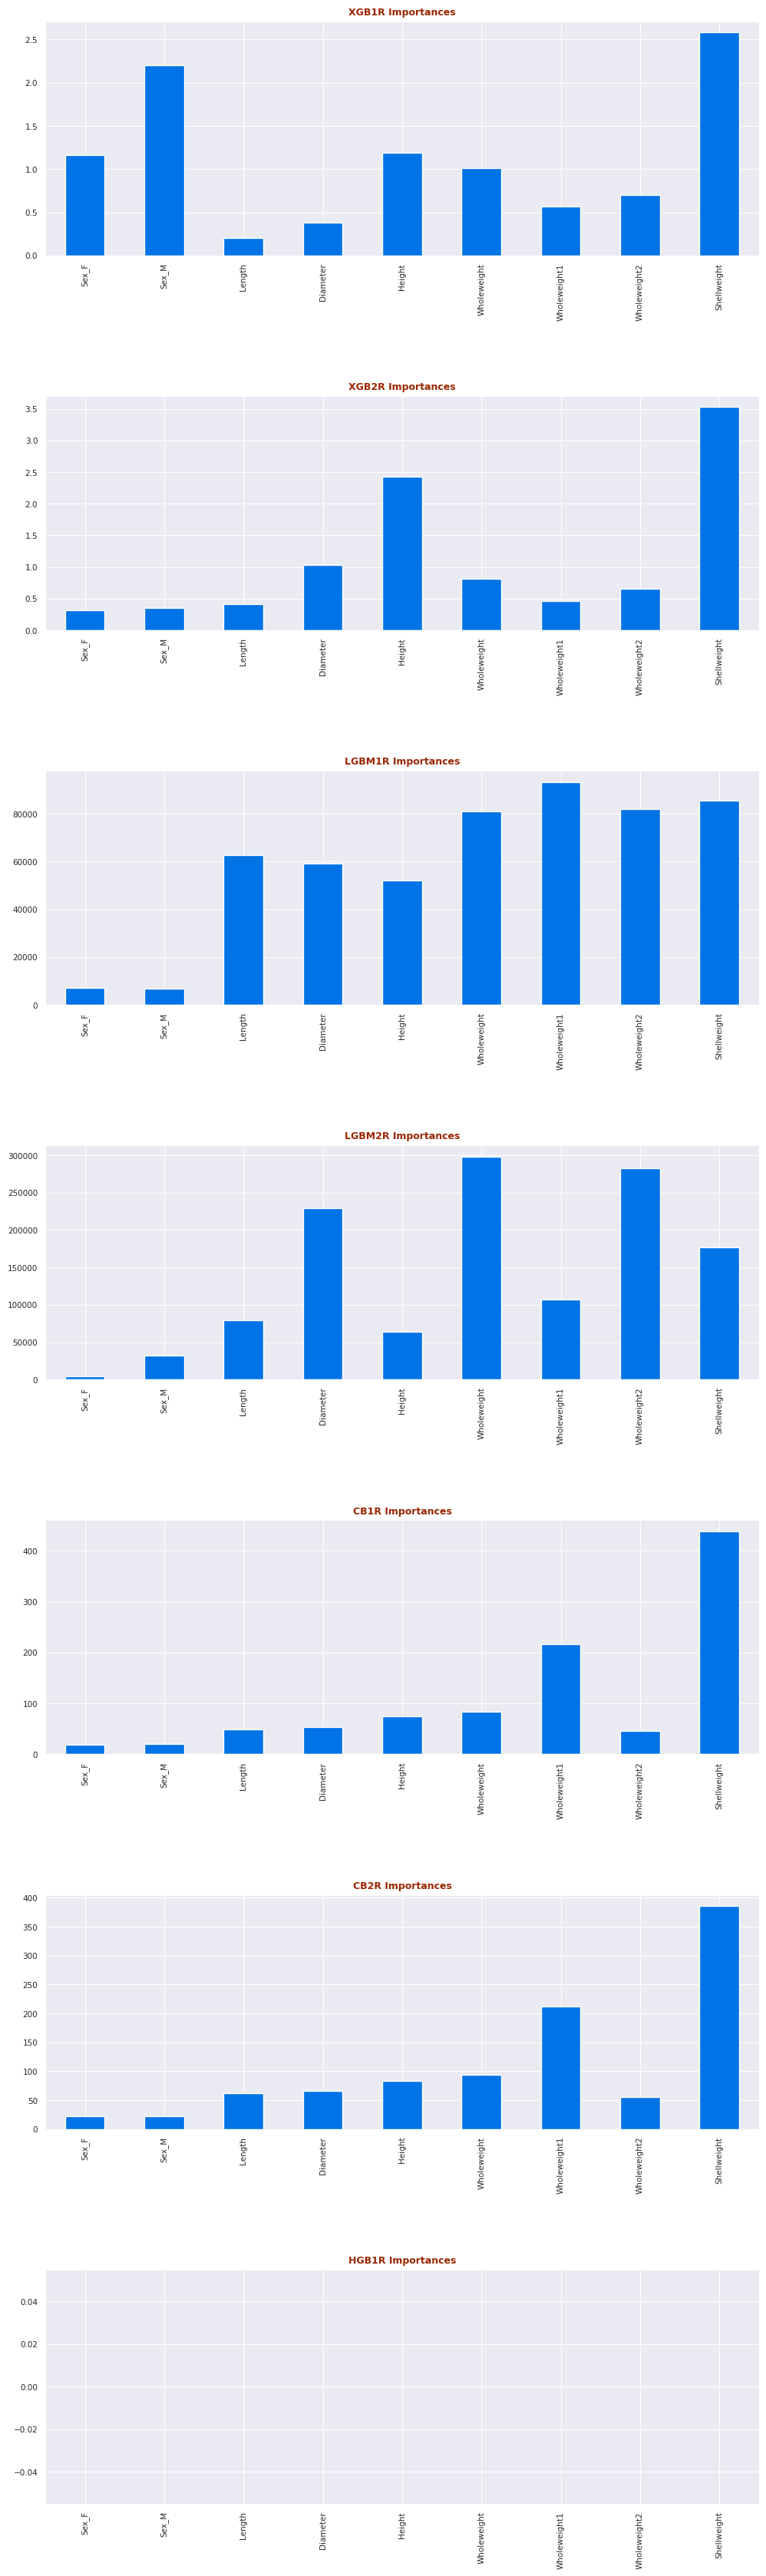

CPU times: user 2.35 s, sys: 151 ms, total: 2.5 s
Wall time: 2.26 s


In [17]:
%%time 

if CFG.ML == "Y":
    md.MakeMLPlots();

In [18]:
%%time 

if CFG.ML == "Y":         
    pp.sub_fl[CFG.target] = np.clip(np.expm1(Mdl_Preds["Ensemble"].values), a_min = 1, a_max = 29);
    
    #  Blending with good public work:-
    sub1 = \
    pd.read_csv(f"/kaggle/input/ps4e4-feature-engineering-regression/submission_comb.csv")[CFG.target].values.flatten();
    
    pp.sub_fl[CFG.target] = \
    np.average(np.c_[pp.sub_fl[CFG.target].values, sub1], 
               axis=1, 
               weights = [0.10, 0.90]
              )
    
    # Post-processing predictions:-   
    pp.sub_fl[CFG.target] = \
    np.where(pp.sub_fl[CFG.target].between(27.5, 29), 29, pp.sub_fl[CFG.target].values);
    
    pp.sub_fl.to_csv(f"Submission_V{CFG.version_nb}.csv", index = False);
    OOF_Preds.to_csv(f"OOF_Preds_V{CFG.version_nb}.csv", index = False);
    Mdl_Preds.to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv", index = False);
    
    display(pp.sub_fl.head(10).style.set_caption(f"\nSubmission file\n").format(precision = 3));
    
print();
collect();

,id,Rings
0,90615,9.782
1,90616,9.701
2,90617,9.771
3,90618,10.529
4,90619,7.610
5,90620,9.271
6,90621,11.205
7,90622,6.122
8,90623,7.934
9,90624,10.859



CPU times: user 3 s, sys: 41.8 ms, total: 3.05 s
Wall time: 3.08 s


<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > NEXT STEPS<br><div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Better feature exploration- we need to pay special attention to the rare categories <br>
2. Better tuned models <br>
3. Improved blending strategy <br>
4. Better post-processing <br>
5. Better model selection and usage <br>
</div>